In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pathlib

# local imports
from eval_utils import(
    datacube_evaluator
)
from utils import(
    get_index_to_name, 
    get_num_classes, 
    plateid_to_fits_file
)
from comp_fns import visualize_gal_labels

data_dir = pathlib.Path('/qfs/projects/gumby/data/manga')
results_dir = pathlib.Path('/qfs/projects/gumby/results/weights/manga/')

# Evaluating on single datacube

Found 2660 npy files in /qfs/projects/gumby/data/manga/processed/patches/logOH/global/11978-12703
Evaluating model...
Found 2736 npy files in /qfs/projects/gumby/data/manga/processed/patches/logOH/global/11975-12705
Evaluating model...


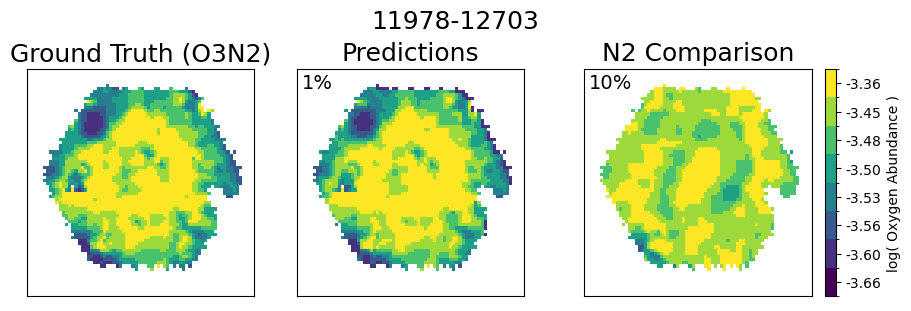

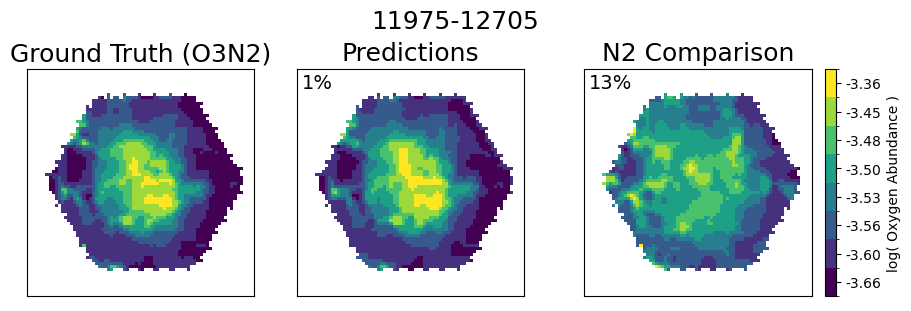

In [2]:
device = torch.device('cuda:0')

OH_key = 'extra'
num_classes=get_num_classes(OH_key)

plate_ids = ['11978-12703','11975-12705']
model_names = ['OH_2_easy']
metrics = ['MAPE']

for plate_id in plate_ids:
    fits_file = plateid_to_fits_file(plate_id)

    for model_name in model_names:
        # output is a dictionary with predictions and ground truth labels
        output = datacube_evaluator(
            fits_file, 
            model_weights_dir=results_dir / model_name,
            OH_key=OH_key,
            num_classes=num_classes,
            device=device,
            num_workers=4,
        )

        for metric in metrics:
            visualize_gal_labels(
                plate_id, 
                output, 
                title=plate_id,
                OH_key=OH_key, 
                OH_log=True,
                metric=metric,
                save_fig=False,
                output_path=f'./figs/{model_name}/{metric}_{plate_id}.png',
                cb_label='log( Oxygen Abundance )'
            )

# Evaluating full test data set

In [3]:
from eval_utils import(
    get_test_dataloader,
    load_trained_SSFTT_model,
    predictions,
    calc_eval_metrics
)

from gumby_utils.plotting import plot_confusion_matrix

You are using the gumby utils package stored at:
/home/byle431/gumby/gumby-utils/gumby_utils/__init__.py


In [4]:
device = torch.device('cuda:0')

split_dir='OH_2'
model_name = 'OH_2_easy'
OH_key='extra'
easy_splits = True if 'easy' in model_name else False

num_classes = get_num_classes(OH_key)
model_weights_dir = results_dir / model_name

test_dataloader = get_test_dataloader(
    split_dir=split_dir,
    patch_norm='global',
    spatial_patch_size=7,
    normalize=False,
    OH_key=OH_key,
    min_wave_ind=0,
    max_wave_ind=2040,
    batch_size=2048,
    num_workers=4,
    easy_splits=easy_splits,
)

# load up trained model
model = load_trained_SSFTT_model(
    model_weights_dir=model_weights_dir, 
    spatial_patch_size=7, 
    device=device,
    num_classes=num_classes
)

collecting predictions. acc: 22.990: 100%|██████████| 31/31 [16:50<00:00, 32.60s/it] 


accuracy: 0.740
MSE: 0.001
MAE: 0.014
MAPE: 0.033


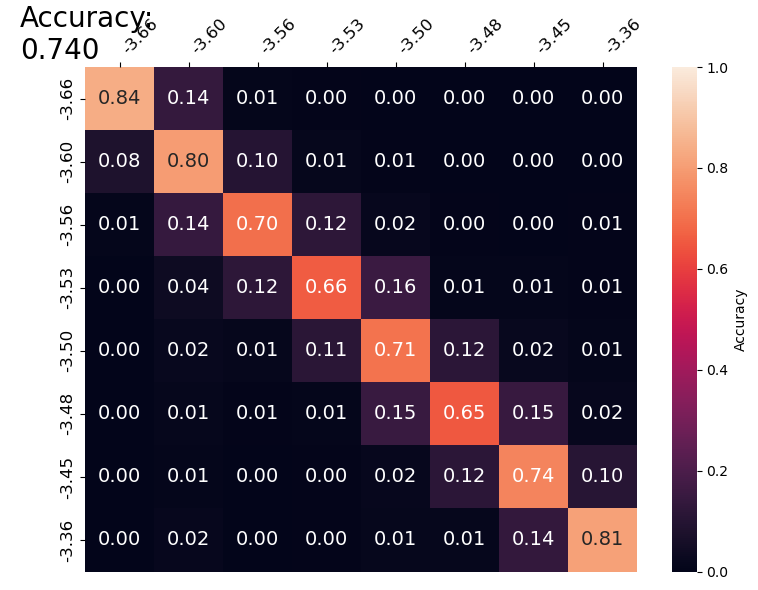

In [5]:
# run on test data split
acc, preds, labs = predictions(test_dataloader, model,  device=device)
metrics = calc_eval_metrics(labs, preds, OH_key=OH_key)

for key,val in metrics.items():
    print(f'{key}: {val:.3f}')

index_to_name = get_index_to_name(OH_key, log=True)
class_list = [v for k,v in index_to_name.items()]
# Generate and plot confusion matrix, accuracy 
plot_confusion_matrix(
    preds,
    labs,
    class_list=class_list,
    save_figure=False,
    output_path=f'./figs/confusion/{model_name}.png',
    normalized=True,
)

# Monitor training curves

100


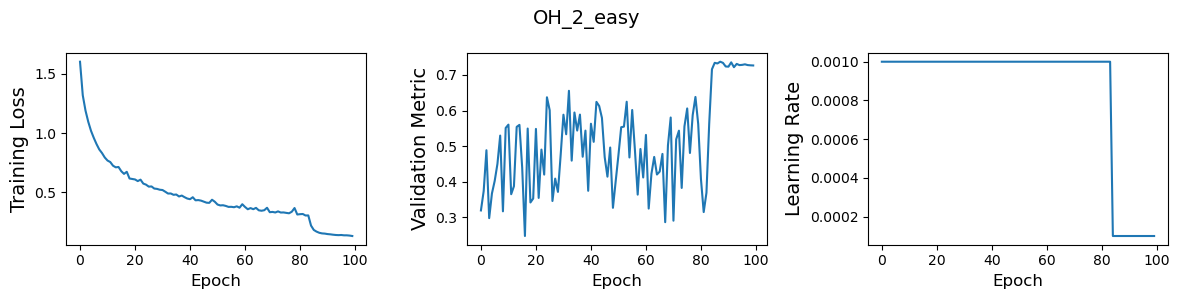

In [6]:
# load in trained weights
model_name =  'OH_2_easy'
model_weights_dir = results_dir / model_name

# whether or not to log the y-axis scale
log=False

fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharex=True, figsize=(12,3))
[ax.set_xlabel('Epoch', size=12) for ax in [ax1,ax2,ax3]]
ax1.set_ylabel('Training Loss', size=14)
ax2.set_ylabel('Validation Metric', size=14)
ax3.set_ylabel('Learning Rate', size=14)

tc = torch.load( model_weights_dir / 'train_curve_loss.pt').numpy()
vc = torch.load( model_weights_dir / 'val_curve_acc.pt').numpy()
lr = torch.load( model_weights_dir / 'lr_curve.pt').numpy()

tc = tc[tc > 0.0]
vc = vc[vc > 0.0]
lr = lr[lr > 0.0]

print(len(tc))

epochs = np.arange(len(tc))

ax1.plot(np.arange(len(tc)), tc)
ax2.plot(np.arange(len(vc)), vc)
ax3.plot(np.arange(len(lr)), lr)

if log:
    [ax.set_yscale('log') for ax in fig.axes]

plt.suptitle(model_weights_dir.relative_to(results_dir).as_posix(), size=14)
plt.tight_layout()